<a href="https://colab.research.google.com/github/martinmowns/Data-Science-Project/blob/main/Churn_Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages below....

In [1]:
!pip install lazypredict
!pip install shap
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 886 kB/s 
     |████████████████████████████████| 1.2 MB 15.0 MB/s 
     |████████████████████████████████| 10.1 MB 48.7 MB/s 
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 21.0 MB/s 
     |████████████████████████████████| 248 kB 41.5 MB/s 
     |████████████████████████████████| 269 kB 57.7 MB/s 
     |████████████████████████████████| 127.6 MB 19 kB/s 
     |████████████████████████████████| 302 kB 50.6 MB/s 
     |████████████████████████████████| 14.5 MB 30.8 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=cc9a087689d54e6edb15030ee59efaf1e38f63601d6b487b5bc470cedb8fc6b1
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: num

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 2.9 MB/s 


Import libraries below

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from gensim.models import Word2Vec
from scipy.stats import zscore

In [3]:
pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.options.display.max_rows = 500 # this will set limit of columns to 500

## Load Dataset

In [4]:
df_full = pd.read_csv('https://raw.githubusercontent.com/raihanrnj/fsb_mentoring/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
## Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
df_full = reduce_mem_usage(df_full)

Mem. usage decreased to  0.99 Mb (11.9% reduction)


In [7]:
df_full.shape

(7043, 21)

### Describe Dataset *df_full_train*

In [8]:
df_full.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.84375,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.93750,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.84375,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.31250,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.68750,151.65,Yes


In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int8   
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int8   
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
print(df_full.shape)
df_full.describe().T

(7043, 21)


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.000,0.000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.000,55.000,72.00
MonthlyCharges,7043.0,inf,30.078125,18.25,35.5,70.375,89.875,118.75


## Data Preparation

In [11]:
df_full.drop(['customerID'], axis=1, inplace=True)

In [12]:
df_full.rename(columns={'Churn':'target'}, inplace=True)

In [13]:
df_full['target'].replace('Yes',1,inplace=True)
df_full['target'].replace('No',0,inplace=True)

In [14]:
def clean_string(string):
    string = str(string)
    if ' ' in string or string.lower()=='nan' or string.strip(' ')=='':
        return np.nan
    string = string.strip(' ').lower()
    return string

df_full.loc[:, 'TotalCharges'] = df_full['TotalCharges'].apply(clean_string)

In [15]:
display(df_full.head(4))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.84375,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.93750,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.84375,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.31250,1840.75,0


### 1. Handling Missing Value

In [16]:
df_class = df_full.copy()

In [17]:
# Check if we have any NaN values
df_class.isnull().values.any()

True

In [18]:
def get_percentMissing(df1):
    percent_missing = df1.isnull().sum() * 100 / len(df1)
    tot_missing = df1.isnull().sum() 
    missing_value_df = pd.DataFrame({'column_name': df1.columns,
                                     'total_missing': tot_missing,
                                     'percent_missing': percent_missing})

    missing_value_df.sort_values('percent_missing',inplace=True)
    a4_dims = (25, 10)
    # df = mylib.load_data()
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(x='column_name', y='percent_missing',ax=ax, data=missing_value_df[-10:],)

    
    return missing_value_df.reset_index(drop=True)

,column_name,total_missing,percent_missing
0,gender,0,0.000000
1,MonthlyCharges,0,0.000000
2,PaymentMethod,0,0.000000
3,PaperlessBilling,0,0.000000
4,Contract,0,0.000000
5,StreamingMovies,0,0.000000
6,StreamingTV,0,0.000000
7,TechSupport,0,0.000000
8,DeviceProtection,0,0.000000
9,OnlineBackup,0,0.000000


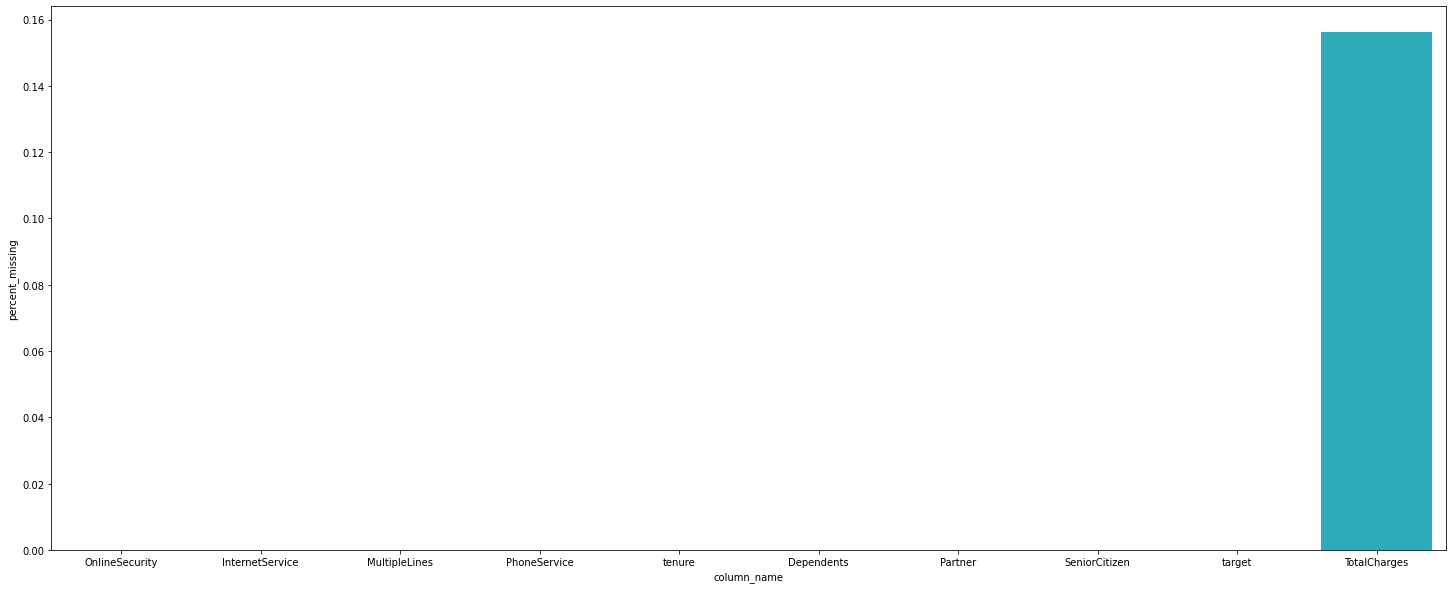

In [19]:
get_percentMissing(df_class)

#### a. Using Simple imputer (mean, median,mode)

In [20]:
# Handle missing values
from sklearn.impute import SimpleImputer

# imp = Imputer(missing_values="NaN", strategy="mean")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # ['mean', 'median', 'most_frequent', 'constant']

df_class['TotalCharges'] = imputer.fit_transform(df_class['TotalCharges'].to_numpy().reshape(-1,1))
df_class['TotalCharges'] = pd.Series(df_class['TotalCharges'])

# df_class.fillna(value = {'location_type':'unknown'})

In [21]:
# Check if we have any NaN values
df_class.isnull().values.any()

False

#### b. Using Mice

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
df_class['TotalCharges'] =imp.fit_transform(df_class['TotalCharges'].to_numpy().reshape(-1,1))
df_class['TotalCharges'] = pd.Series(df_class['TotalCharges'])

In [23]:
# Check if we have any NaN values
df_class.isnull().values.any()

False

### Handling outlier

In [24]:
# using zscore
from scipy import stats

print(f'Jumlah baris sebelum memfilter outlier: {len(df_class)}')

filtered_entries = np.array([True] * len(df_class))
num_var = df_class.select_dtypes(exclude=['object']).columns.tolist()
for col in num_var:
    zscore = abs(stats.zscore(df_class[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    
df_class = df_class[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df_class)}')

Jumlah baris sebelum memfilter outlier: 7043
Jumlah baris setelah memfilter outlier: 7043


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  # numbers and complex types with non-native byteorder


### Transform Data

In [25]:
# Encode string values in data into numerical values
df_class["TotalCharges"] = pd.to_numeric(df_class["TotalCharges"])

In [26]:
df_class.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.84375,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.93750,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.84375,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.31250,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.68750,151.65,1


In [27]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int8   
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int8   
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## Exploratory Data Analysis

In [28]:
cat_var = df_class.select_dtypes(include=['object']).columns.tolist()
num_var = df_class.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical Variabel : ", cat_var)
print("Num Variabel : ", num_var)

Categorical Variabel :  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Num Variabel :  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'target']


#### 1. Univariate Analysis
*   Categorical Univariate Analysis:

Calculate the percentage of ' gender ' variable 



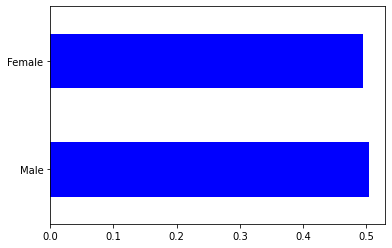


Calculate the percentage of ' Partner ' variable 



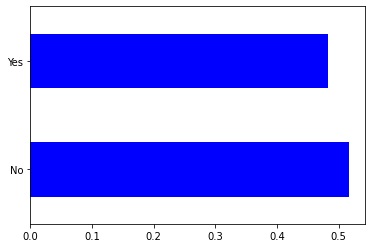


Calculate the percentage of ' Dependents ' variable 



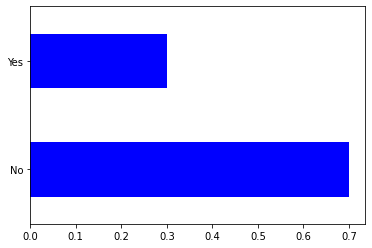


Calculate the percentage of ' PhoneService ' variable 



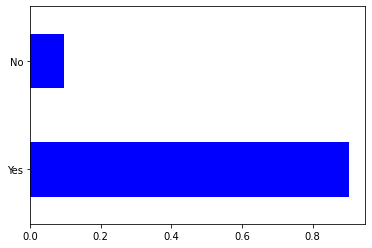


Calculate the percentage of ' MultipleLines ' variable 



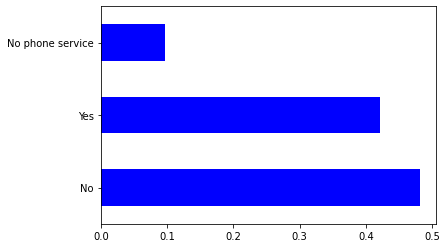


Calculate the percentage of ' InternetService ' variable 



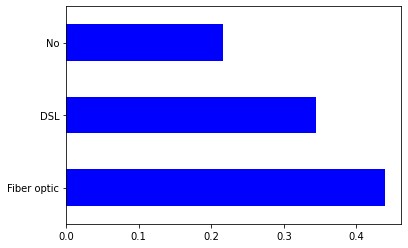


Calculate the percentage of ' OnlineSecurity ' variable 



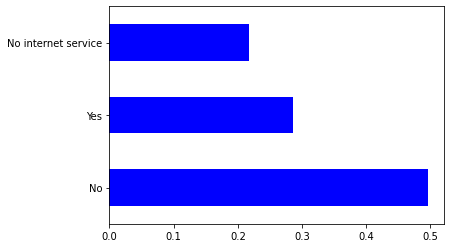


Calculate the percentage of ' OnlineBackup ' variable 



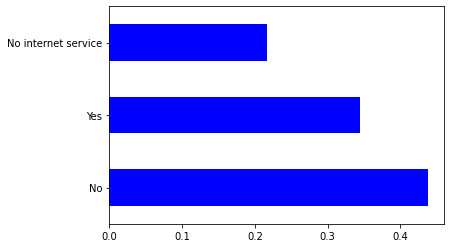


Calculate the percentage of ' DeviceProtection ' variable 



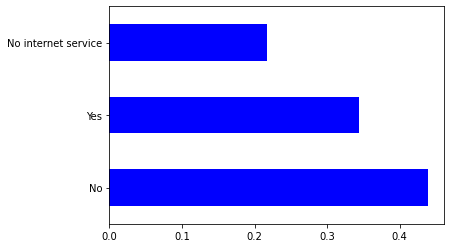


Calculate the percentage of ' TechSupport ' variable 



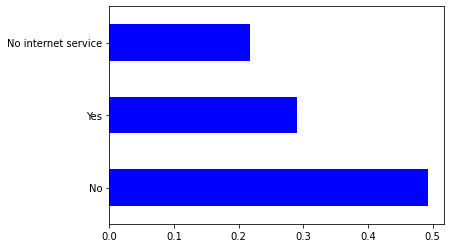


Calculate the percentage of ' StreamingTV ' variable 



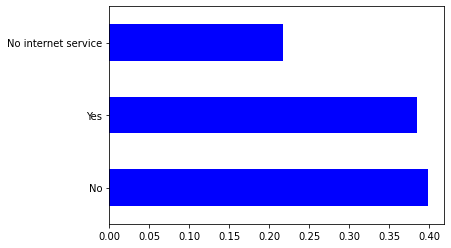


Calculate the percentage of ' StreamingMovies ' variable 



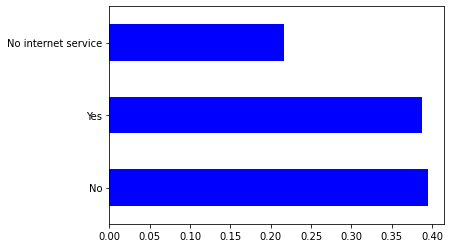


Calculate the percentage of ' Contract ' variable 



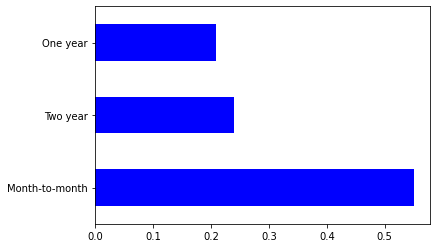


Calculate the percentage of ' PaperlessBilling ' variable 



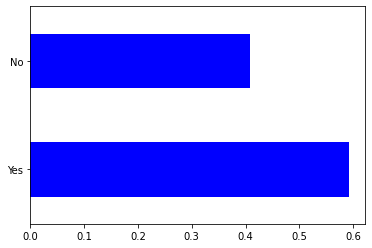


Calculate the percentage of ' PaymentMethod ' variable 



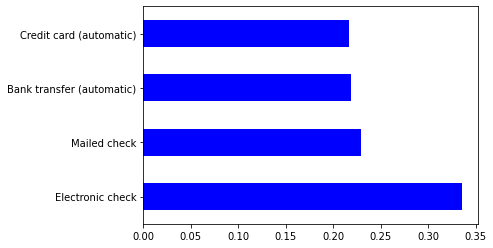

In [29]:
for i in cat_var:
 
  # Let's calculate the percentage of each category.
  df_class[i].value_counts(normalize=True)
  print("Calculate the percentage of '",i,"' variable \n")
  #plot the bar graph of percentage job categories
  df_class[i].value_counts(normalize=True).plot.barh(color="blue")
  plt.show()
  print("="*30,"\n")

  

*   Numerical Univariate Analysis:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


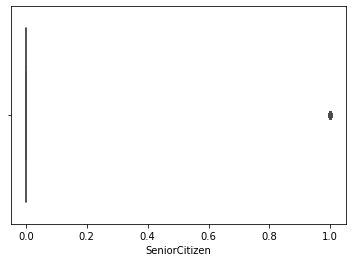

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


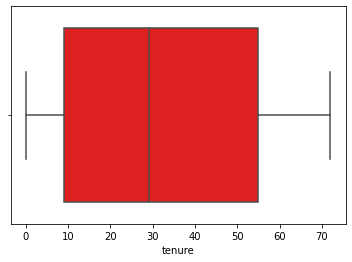

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


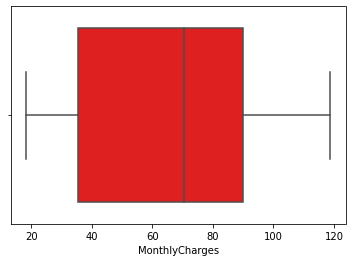

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


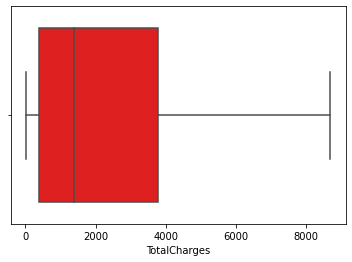

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


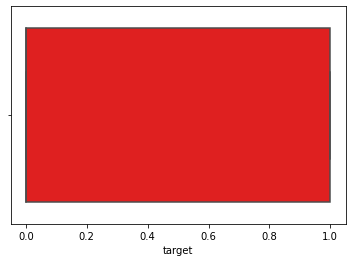

In [30]:
# boxplot
for i in range(len(num_var)):
  sns.boxplot(df_class[num_var[i]], color="red", orient="h")
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


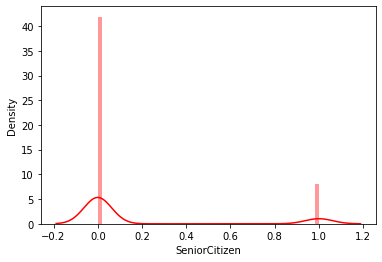

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


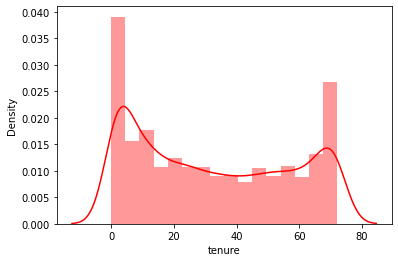

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


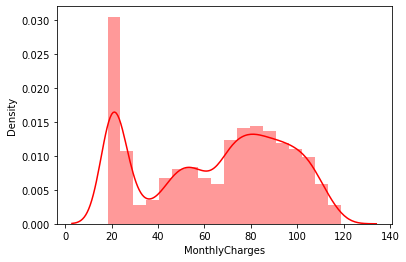

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


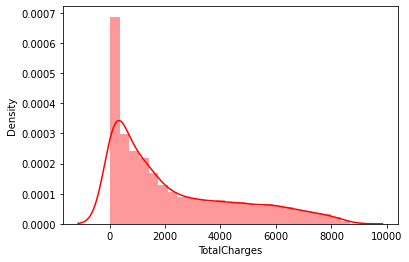

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


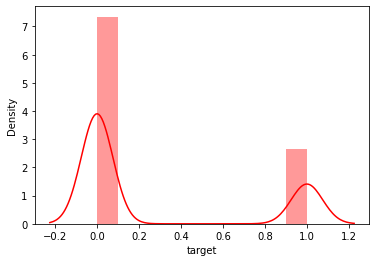

In [31]:
# dist plot
for i in range(len(num_var)):
  sns.distplot(df_class[num_var[i]], color="red")
  plt.show()

*   Bivariate Analyisis

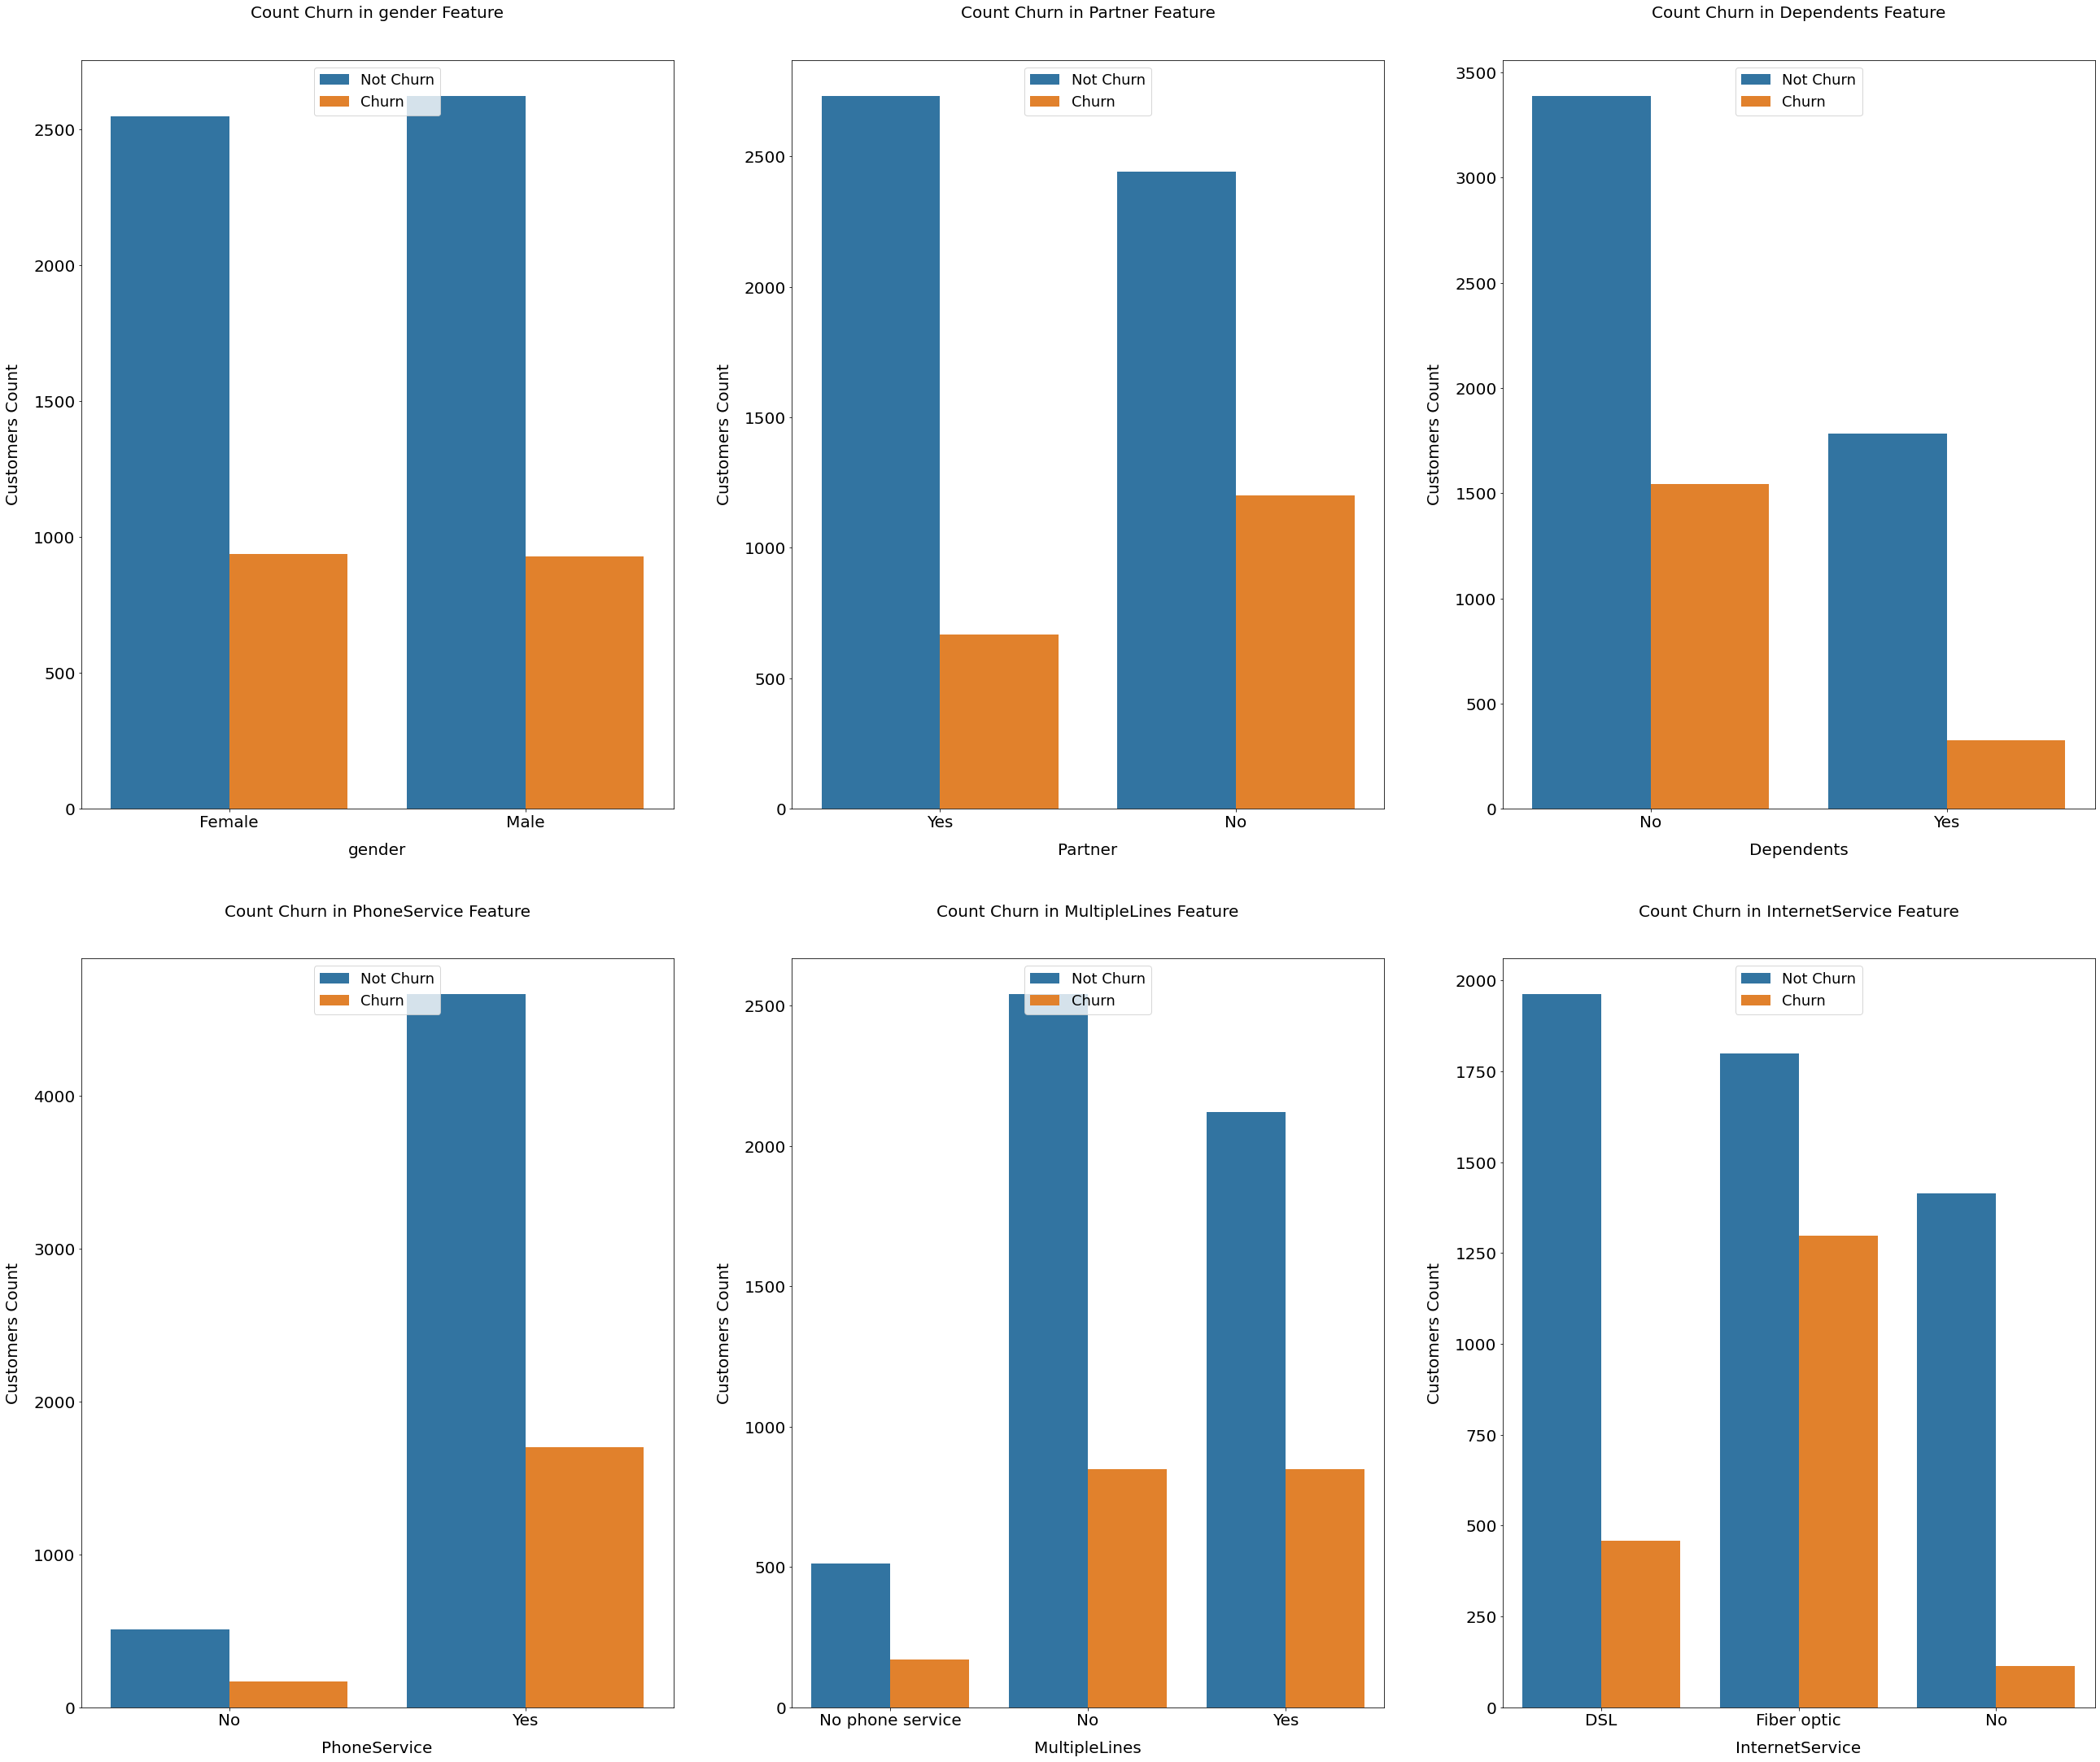

In [32]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (25, 25))
plt.subplots_adjust(right = 1.5, top = 1.25)

for i, feature in enumerate(cat_var[:6], 1):
  plt.subplot(2, 3, i)
  sns.countplot(x = feature, hue = 'target', data = df_class)

  plt.xlabel('{}'.format(feature), size = 20, labelpad = 15)
  plt.ylabel('Customers Count', size = 20, labelpad = 15)
  plt.tick_params(axis = 'x', labelsize = 20)
  plt.tick_params(axis = 'y', labelsize = 20)

  plt.legend(['Not Churn', 'Churn'], loc = 'upper center', prop = {'size': 18})
  plt.title('Count Churn in {} Feature'.format(feature), size = 20, y = 1.05)

plt.show()

*   Multivariate Analysis

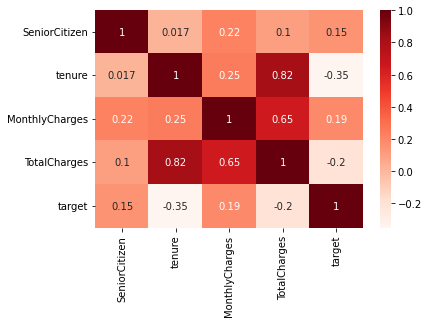

In [33]:
df_class.corr()

#plot the correlation matrix of salary, balance and age in data dataframe.
sns.heatmap(df_class.corr(), annot=True, cmap = 'Reds')
plt.show()

## Feature Engineering

#### Use code below for feature encoding in specifiq columns

In [34]:
# categorical_features = ['location_number', 'location_type', 'status_x',
#                  'delivery_available']

# for feature in categorical_features:
#     df_class = encode_and_bind(df_class, feature)

#### Use code below for feature encoding in all categorical columns

In [35]:
# Use pandas get_dummies
df_class_encoded = pd.get_dummies(df_class.drop(['target'], axis=1))
df_class_encoded['target'] = df_class['target']
df_class_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,target
0,0,1,29.84375,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,0,34,56.93750,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,0,2,53.84375,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1
3,0,45,42.31250,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0
4,0,2,70.68750,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1


In [36]:
df_class_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int8   
 1   tenure                                   7043 non-null   int8   
 2   MonthlyCharges                           7043 non-null   float16
 3   TotalCharges                             7043 non-null   float64
 4   gender_Female                            7043 non-null   uint8  
 5   gender_Male                              7043 non-null   uint8  
 6   Partner_No                               7043 non-null   uint8  
 7   Partner_Yes                              7043 non-null   uint8  
 8   Dependents_No                            7043 non-null   uint8  
 9   Dependents_Yes                           7043 non-null   uint8  
 10  PhoneService_No                          7043 no

In [37]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from  sklearn.metrics import roc_curve, auc
import shap

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.4f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.4f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.4f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.4f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.4f" % auc(fpr, tpr))

def built_in_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def shap_feature_importance(model_input,X):
    explainer = shap.TreeExplainer(model_input)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")
    print("="*30)
    shap.summary_plot(shap_values, X)
  

### Split Dataset

In [38]:
from sklearn.model_selection import train_test_split 

X = df_class_encoded.drop(['target'], axis=1)
y = df_class_encoded['target']


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

### Handling imbalanced Dataset (Resampling Dataset)

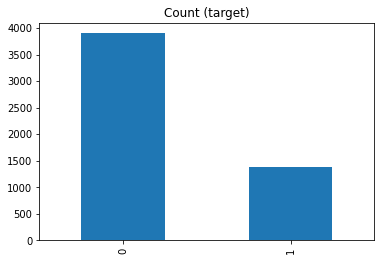

In [39]:
y_train.value_counts().plot(kind='bar', title='Count (target)');

In [40]:
# Use code below for Oversampling 
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [41]:
# Use code below for Undersampling 
# from imblearn.under_sampling import RandomUnderSampler

# undersample = RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

After Sampling Data:
1    3900
0    3900
Name: target, dtype: int64


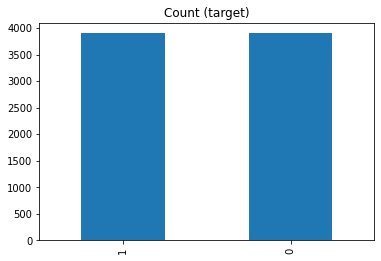

In [42]:
print('After Sampling Data:')
print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Count (target)');

In [43]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [44]:
X_train[:3]

array([[1.        , 0.08333333, 0.26026119, 0.02818486, 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.625     , 0.01741294, 0.10011539, 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1. 

## Modelling

#### a. Train Model

1. Using Based Model (Logistic Regression)

In [45]:
###We import the model that will be used. 
from sklearn.linear_model import LogisticRegression

# Create an instance of the model. 
logreg = LogisticRegression() 
# Training the model. 
logreg.fit(X_train,y_train) 
# Do prediction. 
y_pred = logreg.predict(X_test)

print(eval_classification(logreg,y_pred,X_train,y_train, X_test, y_test))
print("="*25)

Accuracy (Test Set): 0.8030
Precision (Test Set): 0.6691
Recall (Test Set): 0.5688
F1-Score (Test Set): 0.6149
AUC: 0.7306
None


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [46]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1137  137]
 [ 210  277]]

True Positives(TP) =  1137

True Negatives(TN) =  277

False Positives(FP) =  137

False Negatives(FN) =  210


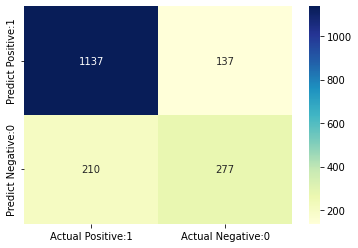

In [47]:
# visualize confusion matrix with seaborn heatmap
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1274
           1       0.67      0.57      0.61       487

    accuracy                           0.80      1761
   macro avg       0.76      0.73      0.74      1761
weighted avg       0.80      0.80      0.80      1761



In [49]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [50]:
accuracy = (TP+TN) / float(TP+TN+FP+FN)

print('Classification accuracy : {0:0.4f}'.format(accuracy))

Classification accuracy : 0.8030


In [51]:
class_error = (FP+FN) / float(TP+TN+FP+FN)

print('Classification Error : {0:0.4f}'.format(class_error))

Classification Error : 0.1970


In [52]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))


Precision : 0.8925


In [53]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity or TPR : {0:0.4f}'.format(recall))

Recall or Sensitivity or TPR : 0.8441


1. TRUE POSITIVE RATE (TPR)

In [54]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.8441


2. FALSE POSITIVE RATE (FPR)

In [55]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.3309


3. Spacificty

In [56]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.6691


#### Threshold

In [57]:
# print the first 10 predicted probabilities of two classes- 0 and 1

y_pred_prob = logreg.predict_proba(X_test)[0:10]

y_pred_prob

array([[0.2840122 , 0.7159878 ],
       [0.24110442, 0.75889558],
       [0.80876291, 0.19123709],
       [0.89508254, 0.10491746],
       [0.98015791, 0.01984209],
       [0.98907202, 0.01092798],
       [0.93874776, 0.06125224],
       [0.99133323, 0.00866677],
       [0.90709909, 0.09290091],
       [0.98814466, 0.01185534]])

In [58]:
# store the probabilities in dataframe

y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - No Rain tomorrow (1)', 'Prob of - Rain tomorrow (0)'])

y_pred_prob_df

,Prob of - No Rain tomorrow (1),Prob of - Rain tomorrow (0)
0,0.284012,0.715988
1,0.241104,0.758896
2,0.808763,0.191237
3,0.895083,0.104917
4,0.980158,0.019842
5,0.989072,0.010928
6,0.938748,0.061252
7,0.991333,0.008667
8,0.907099,0.092901
9,0.988145,0.011855


In [59]:
# store the predicted probabilities for class 1 - Probability of rain

y_pred1 = logreg.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

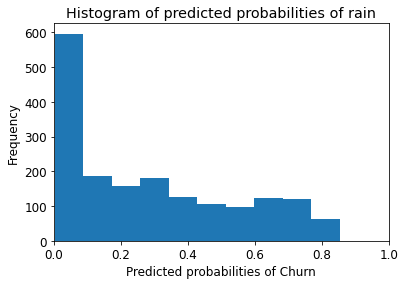

In [60]:
# plot histogram of predicted probabilities


# adjust the font size 
plt.rcParams['font.size'] = 12


# plot histogram with 10 bins
plt.hist(y_pred1, bins = 10)


# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of rain')


# set the x-axis limit
plt.xlim(0,1)


# set the title
plt.xlabel('Predicted probabilities of Churn')
plt.ylabel('Frequency')

In [61]:
from sklearn.preprocessing import binarize

for i in range(1,7):
    
    cm1=0
    
    y_pred1 = logreg.predict_proba(X_test)[:,1]
    
    y_pred1 = y_pred1.reshape(-1,1)

    y_pred2 = binarize(y_pred1,  threshold=i/10)
    
    # y_pred2 = np.where(y_pred2 == 1, 'Yes', 'No')
    # print(y_test)
    # print(y_pred2)
    
    
    cm1 = confusion_matrix(y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
           
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
            cm1[0,1],'Type I errors( False Positives), ','\n\n',
           
            cm1[1,0],'Type II errors( False Negatives), ','\n\n',
           
           'Accuracy score: ', (accuracy_score(y_test, y_pred2)), '\n\n',
           
           'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
           'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[616 658]
 [ 28 459]] 

 with 1075 correct predictions,  

 658 Type I errors( False Positives),  

 28 Type II errors( False Negatives),  

 Accuracy score:  0.6104486087450313 

 Sensitivity:  0.9425051334702259 

 Specificity:  0.4835164835164835 



With 0.2 threshold the Confusion Matrix is  

 [[794 480]
 [ 55 432]] 

 with 1226 correct predictions,  

 480 Type I errors( False Positives),  

 55 Type II errors( False Negatives),  

 Accuracy score:  0.6961953435547984 

 Sensitivity:  0.8870636550308009 

 Specificity:  0.6232339089481946 



With 0.3 threshold the Confusion Matrix is  

 [[946 328]
 [ 98 389]] 

 with 1335 correct predictions,  

 328 Type I errors( False Positives),  

 98 Type II errors( False Negatives),  

 Accuracy score:  0.75809199318569 

 Sensitivity:  0.7987679671457906 

 Specificity:  0.7425431711145997 



With 0.4 threshold the Confusion Matrix is  

 [[1054  220]
 [ 152  335]] 

 with 1389 correct p

In [62]:

y_pred1 = logreg.predict_proba(X_test)[:,1]

y_pred1 = y_pred1.reshape(-1,1)

y_pred2 = binarize(y_pred1, threshold= 0.5)

# predicted_final = np.where(y_pred2 == 1, 'Yes', 'No')

In [63]:
y_pred2[0:10]

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [64]:

y_pred1 = logreg.predict_proba(X_test)[:,1]

y_pred1 = y_pred1.reshape(-1,1)

y_pred2 = binarize(y_pred1, threshold= 0.3)

# predicted_final = np.where(y_pred2 == 1, 'Yes', 'No')

In [65]:
y_pred2[0:10]

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

## ROC AUC

In [66]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred2)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7707


2. Using Ensemble Learning Model XGboost

In [67]:
from xgboost import XGBClassifier

# Create an instance of the model. 
xg = XGBClassifier(random_state=50)
# Training the model. 
xg.fit(X_train, y_train)
# Do prediction. 
y_pred = xg.predict(X_test)

print(eval_classification(xg,y_pred,X_train,y_train, X_test, y_test))
print("="*25)


Accuracy (Test Set): 0.7729
Precision (Test Set): 0.5960
Recall (Test Set): 0.5544
F1-Score (Test Set): 0.5745
AUC: 0.7054
None


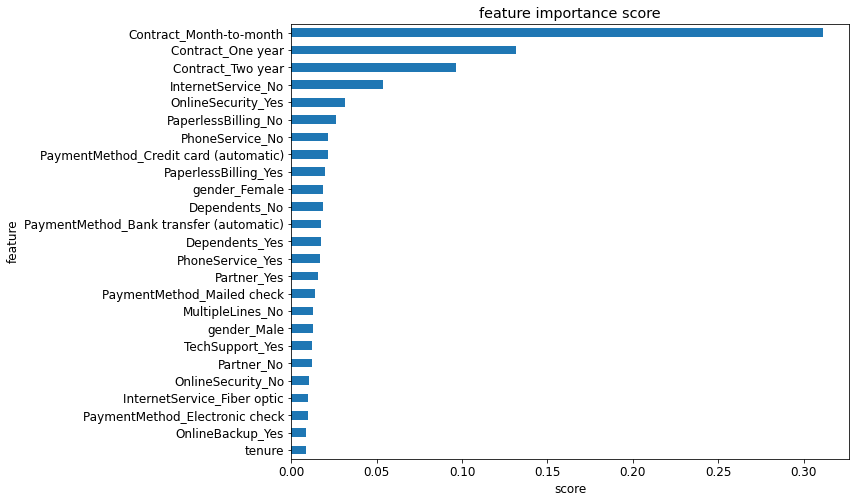

In [68]:
built_in_feature_importance(xg)

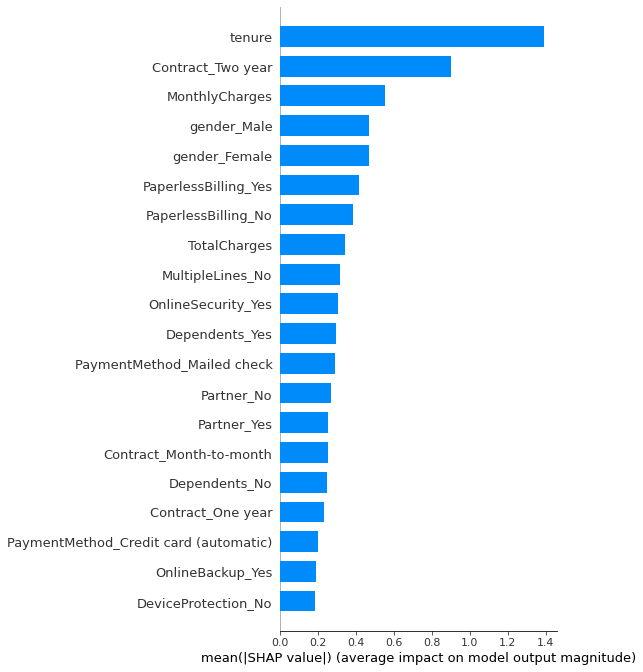

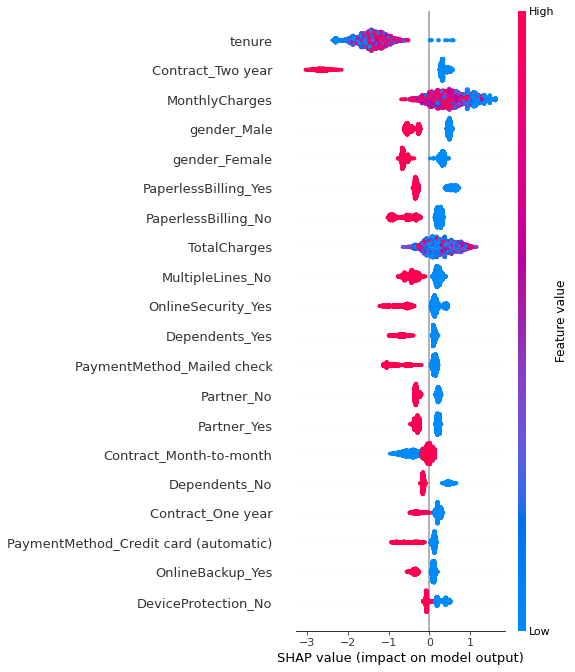

In [69]:
shap_feature_importance(xg,X)

3. Using AdaBoost Classifier

In [70]:
from sklearn.ensemble import AdaBoostClassifier

# Create an instance of the model. 
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
# Training the model. 
ada.fit(X_train, y_train)
# Do prediction. 
y_pred = ada.predict(X_test)

print(eval_classification(ada,y_pred,X_train,y_train, X_test, y_test))
print("="*25)

Accuracy (Test Set): 0.7865
Precision (Test Set): 0.6135
Recall (Test Set): 0.6160
F1-Score (Test Set): 0.6148
AUC: 0.7338
None


4. Using NearestCentroid

In [71]:
from sklearn.neighbors import NearestCentroid

# Create an instance of the model. 
nc = NearestCentroid()
# Training the model. 
nc.fit(X_train, y_train)
# Do prediction. 
y_pred = nc.predict(X_test)

print(eval_classification(nc,y_pred,X_train,y_train, X_test, y_test))
print("="*25)

Accuracy (Test Set): 0.7291
Precision (Test Set): 0.5065
Recall (Test Set): 0.7947
F1-Score (Test Set): 0.6187
AUC: 0.7494
None


5. Using AutoML Selection

In [72]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [73]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.74,0.76,0.76,0.75,0.09
NearestCentroid,0.73,0.75,0.75,0.74,0.05
GaussianNB,0.74,0.75,0.75,0.75,0.05
AdaBoostClassifier,0.79,0.74,0.74,0.79,1.52
NuSVC,0.79,0.74,0.74,0.79,5.87
LinearDiscriminantAnalysis,0.79,0.73,0.73,0.79,0.25
RidgeClassifierCV,0.79,0.73,0.73,0.79,0.12
RidgeClassifier,0.79,0.73,0.73,0.79,0.05
LogisticRegression,0.80,0.73,0.73,0.79,0.23


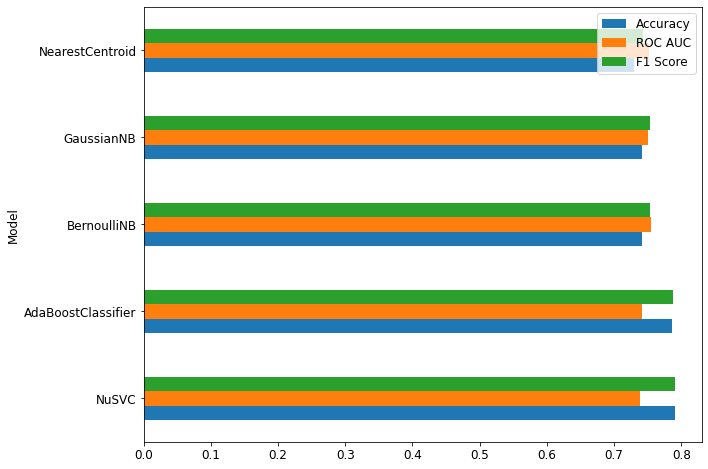

In [74]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

models[:5].reset_index().sort_values(by='Accuracy',ascending=False).plot(x="Model",y=["Accuracy","ROC AUC",	"F1 Score"], kind="barh")

#### b. Fine-Tuning model

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from sklearn.svm import SVC

# define search space
params = dict()
params['C'] = (1e-6, 100.0, 'log-uniform')
params['gamma'] = (1e-6, 100.0, 'log-uniform')
params['degree'] = (1,5)
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the search
search = BayesSearchCV(estimator=SVC(), search_spaces=params, n_jobs=-1, cv=cv)
# perform the search
search.fit(sc.fit_transform(X), y)
# report the best result
print(search.best_score_)
print(search.best_params_)